In [1]:
import pandahouse as ph
connection = {'database':'default',
              'host': 'http://clickhouse.beslan.pro:8080',
              'user':'student', 
              'password':'dpo_python_2020'
             }

In [2]:
query = """
SELECT COUNT(*)
FROM ldn_listings
"""

In [3]:
ph.read_clickhouse(query, connection=connection)

,count()
0,85207


In [4]:
query = '''
SELECT 
room_type,
toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price
FROM
ldn_listings
limit 1000
'''

df = ph.read_clickhouse(query, connection=connection)

In [5]:
df = df.groupby(['room_type'])['price'].quantile(q=0.75).reset_index()

In [6]:
df[df['room_type'] == 'Private room']

,room_type,price
2,Private room,70.0


In [7]:
query = '''
SELECT 
room_type,
toFloat32OrNull(review_scores_rating) as rsr,
toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price
FROM
ldn_listings
where rsr is not null
order by id
limit 1000
'''
df = ph.read_clickhouse(query, connection=connection)
df = df.groupby(['room_type'], as_index=False) \
     .agg({'price': 'mean',
           'rsr': 'mean'})

In [9]:
import seaborn as sns

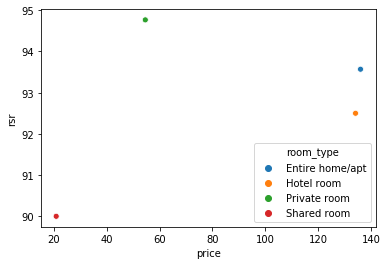

In [10]:
sns.scatterplot(data=df, x ='price', y='rsr', hue='room_type')

In [11]:
q = """
SELECT
    DISTINCT host_id,
    host_verifications
FROM
    ldn_listings
WHERE
    experiences_offered != 'none'
"""

df = ph.read_clickhouse(q, connection=connection)

In [12]:
df = df \
 .host_verifications \
 .apply(lambda x: x.strip('[]').replace("'", '').split(', ')) \
 .explode() \
 .value_counts()

In [13]:
df

phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: host_verifications, dtype: int64

In [14]:
q = """
SELECT  
    neighbourhood_cleansed,
    experiences_offered,
    COUNT(*) AS experiences_count
FROM 
    ldn_listings
WHERE
    experiences_offered != 'none'
GROUP BY
    neighbourhood_cleansed,
    experiences_offered
ORDER BY
    experiences_count DESC
LIMIT 100"""

experiences = ph.read_clickhouse(q, connection=connection)

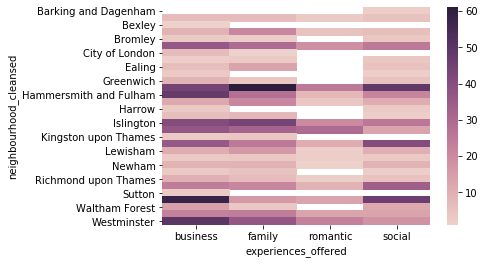

In [15]:
sns.heatmap(experiences.pivot(index= 'neighbourhood_cleansed', \
 columns='experiences_offered', values = 'experiences_count'), \
               cmap=sns.cubehelix_palette(as_cmap=True))

In [16]:
query = '''
SELECT
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price_corr,
    room_type
FROM
    ldn_listings
WHERE
    experiences_offered != 'none'
'''

df = ph.read_clickhouse(query, connection=connection)

In [20]:
import matplotlib.pyplot as plt

%matplotlib inline 

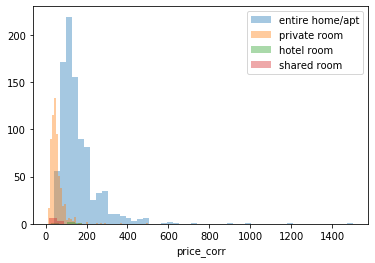

In [21]:
sns.distplot((df.query("room_type=='Entire home/apt'").price_corr), kde=False, label='entire home/apt')
sns.distplot((df.query("room_type=='Private room'").price_corr), kde=False, label='private room')
sns.distplot((df.query("room_type=='Hotel room'").price_corr), kde=False, label='hotel room')
sns.distplot((df.query("room_type=='Shared room'").price_corr), kde=False, label='shared room')
plt.legend()
plt.show()

In [23]:
import numpy as np

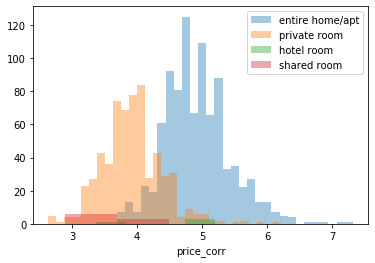

In [24]:
sns.distplot(np.log(df.query("room_type=='Entire home/apt'").price_corr), kde=False, label='entire home/apt')
sns.distplot(np.log(df.query("room_type=='Private room'").price_corr), kde=False, label='private room')
sns.distplot(np.log(df.query("room_type=='Hotel room'").price_corr), kde=False, label='hotel room')
sns.distplot(np.log(df.query("room_type=='Shared room'").price_corr), kde=False, label='shared room')
plt.legend()
plt.show()

In [25]:
query = '''
SELECT 
        room_type
    ,   toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price_corr
    ,   first_review
FROM
        ldn_listings
where first_review > '2010-01-01'
LIMIT 1000
'''
df = ph.read_clickhouse(query, connection=connection)

In [26]:
df['year'] = df.first_review.apply(lambda x: x[:4])

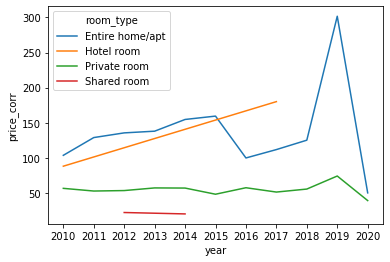

In [27]:
df = df.groupby(['year', 'room_type'], as_index=False) \
    .agg({'price_corr': 'mean'})
sns.lineplot(data=df, hue='room_type', x = 'year', y='price_corr')